In [27]:
# import library 
import wfdb
import pywt
import seaborn
import numpy as np
import tensorflow as tf
import matplotlib.pyplot as plt
from sklearn import metrics
from sklearn.metrics import confusion_matrix
from tensorflow.python.keras import Model, Input
from tensorflow.python.keras.layers import LSTM, Dropout, Dense,Attention, multiply
from tensorflow.python.keras.models import Sequential
from tensorflow.python.keras.layers.core import *
from wfdb import processing
import pandas as pd
from sklearn.model_selection import train_test_split
from sklearn import svm
from sklearn import preprocessing
import seaborn as sns
from scipy.signal import find_peaks
from sklearn.preprocessing import StandardScaler


In [2]:
"""
custom function
"""
# Use the GQRS detection algorithm and correct the peaks
def peaks_hr(sig, peak_inds, fs, title, figsize=(20, 10), saveto=None):
    "Plot a signal with its peaks and heart rate"
    # Calculate heart rate
    hrs = processing.hr.compute_hr(sig_len=sig.shape[0], qrs_inds=peak_inds, fs=fs)
    
    N = sig.shape[0]
    
    fig, ax_left = plt.subplots(figsize=figsize)
    ax_right = ax_left.twinx()
    
    ax_left.plot(sig, color='#3979f0', label='Signal')
    ax_left.plot(peak_inds, sig[peak_inds], 'rx', marker='x', 
                 color='#8b0000', label='Peak', markersize=12)
    ax_right.plot(np.arange(N), hrs, label='Heart rate', color='m', linewidth=2)

    ax_left.set_title(title)

    ax_left.set_xlabel('Time (ms)')
    ax_left.set_ylabel('ECG (mV)', color='#3979f0')
    ax_right.set_ylabel('Heart rate (bpm)', color='m')
    # Make the y-axis label, ticks and tick labels match the line color.
    ax_left.tick_params('y', colors='#3979f0')
    ax_right.tick_params('y', colors='m')
    if saveto is not None:
        plt.savefig(saveto, dpi=600)
    plt.show()


# compute_hr: This is the compute the heart rate
# sig_len: 
# qrs_ins: 
# fs: frequency
def compute_hr(sig_len, qrs_ins, fs):
    heart_rate=np.full(sig_len,np.nan,dtype="float32")

    if len(qrs_inds)<2:
        return heart_rate

    for i in range(0, len(qrs_inds)-2):
            a=qrs_inds[i]
            b=qrs_inds[i+1]
            c=qrs_inds[i+2]
            rr=(b-a)*(1.0/fs)*1000
            hr=60000.0/rr
            heart_rate[b+1:c+1]=hr

            heart_rate[qrs_inds[-1]:]=heart_rate[qrs_inds[-1]]

            return heart_rate
        
# compute_hr_custom: This is the compute the custom hr 
# sig_len: 
# qrs_ins: 
# fs: frequency

def compute_respiratory(r_peak_1, r_peak_2, fs):
     a = r_peak_1
     b = r_peak_2
     rr = (b - a) * (1.0 / fs)
     hr = 60 / rr

     return hr
    
# dont know wtf for this
def denoise(data):
   
    coeffs = pywt.wavedec(data=data, wavelet='db5', level = 9)
    cA9, cD9, cD8, cD7, cD6, cD5, cD4, cD3, cD2, cD1 = coeffs

    threshold = (np.median(np.abs(cD1)) / 0.6745) * (np.sqrt(2 * np.log(len(cD1))))
    cD1.fill(0)
    cD2.fill(0)
    
    for i in range(1, len(coeffs) - 2):
        coeffs[i] = pywt.threshold(coeffs[i], threshold)

    rdata = pywt.waverec(coeffs=coeffs, wavelet='db5')
    return rdata


def plotHeatMap(Y_test, Y_pred):
    con_mat = confusion_matrix(Y_test, Y_pred)
    # 绘图
    plt.figure(figsize=(4, 5))
    seaborn.heatmap(con_mat, annot=True, fmt='.20g', cmap='Blues')
    plt.ylim(0, 5)
    plt.xlabel('Predicted labels')
    plt.ylabel('True labels')
    plt.show()
    
    
    
def buildModel():
    newModel = tf.keras.models.Sequential([
        tf.keras.layers.InputLayer(input_shape=(300, 1)),
        # 第一个卷积层, 4 个 21x1 卷积核
        tf.keras.layers.Conv1D(filters=4, kernel_size=21, strides=1, padding='SAME', activation='tanh'),
        # 第一个池化层, 最大池化,4 个 3x1 卷积核, 步长为 2
        tf.keras.layers.MaxPool1D(pool_size=3, strides=2, padding='SAME'),
        # 第二个卷积层, 16 个 23x1 卷积核
        tf.keras.layers.Conv1D(filters=16, kernel_size=23, strides=1, padding='SAME', activation='relu'),
        # 第二个池化层, 最大池化,4 个 3x1 卷积核, 步长为 2
        tf.keras.layers.MaxPool1D(pool_size=3, strides=2, padding='SAME'),
        # 第三个卷积层, 32 个 25x1 卷积核
        tf.keras.layers.Conv1D(filters=32, kernel_size=25, strides=1, padding='SAME', activation='tanh'),
        # 第三个池化层, 平均池化,4 个 3x1 卷积核, 步长为 2
        tf.keras.layers.AvgPool1D(pool_size=3, strides=2, padding='SAME'),
        # 第四个卷积层, 64 个 27x1 卷积核
        tf.keras.layers.Conv1D(filters=64, kernel_size=27, strides=1, padding='SAME', activation='relu'),
        # 打平层,方便全连接层处理'
        tf.keras.layers.Flatten(),
        # 全连接层,128 个节点 转换成128个节点
        tf.keras.layers.Dense(128, activation='relu'),
        # Dropout层,dropout = 0.2
        tf.keras.layers.Dropout(rate=0.2),
        # 全连接层,5 个节点
        tf.keras.layers.Dense(5, activation='softmax')
    ])
    return newModel

def plotHeatMap(Y_test, Y_pred):
    con_mat = confusion_matrix(Y_test, Y_pred)
    # 绘图
    plt.figure(figsize=(4, 5))
    seaborn.heatmap(con_mat, annot=True, fmt='.20g', cmap='Blues')
    plt.ylim(0, 5)
    plt.xlabel('Predicted labels')
    plt.ylabel('True labels')
    plt.show()


Loading infants 1 ...


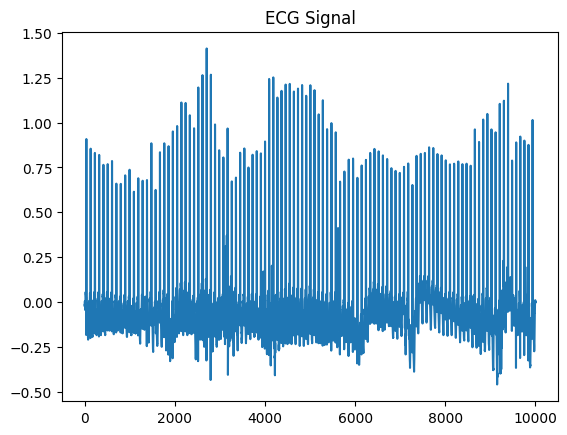

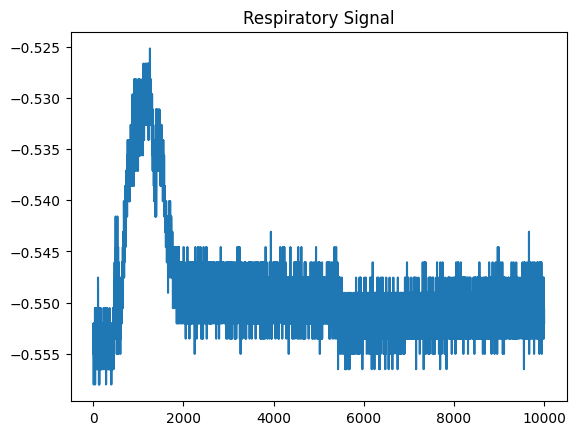

Respiratory rate: 0.00 breaths per minute
Respiratory rate after filter: 2990.00 breaths per minute
ECG slp frequecy: 250 Hz
ECG slp interval every: 0.004 sec
RESP slp frequecy: 500 Hz
RESP slp interval every: 0.004 sec

Loading infants 2 ...


/var/folders/hd/p3q1ts813gq7flnfjj_xpf440000gp/T/ipykernel_1852/706675354.py:163: FutureWarning: The frame.append method is deprecated and will be removed from pandas in a future version. Use pandas.concat instead.
  heart_df = heart_df.append(combination)
/var/folders/hd/p3q1ts813gq7flnfjj_xpf440000gp/T/ipykernel_1852/706675354.py:164: FutureWarning: The frame.append method is deprecated and will be removed from pandas in a future version. Use pandas.concat instead.
  resp_df = resp_df.append(combination)


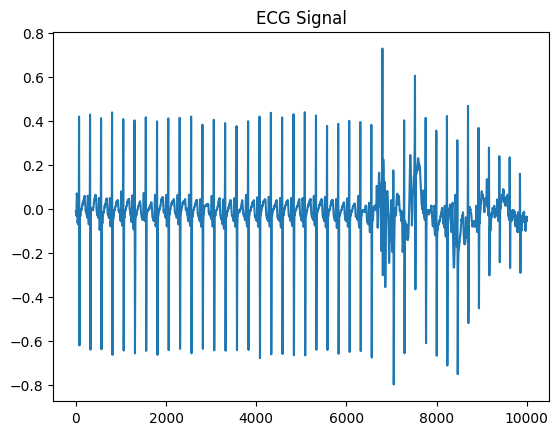

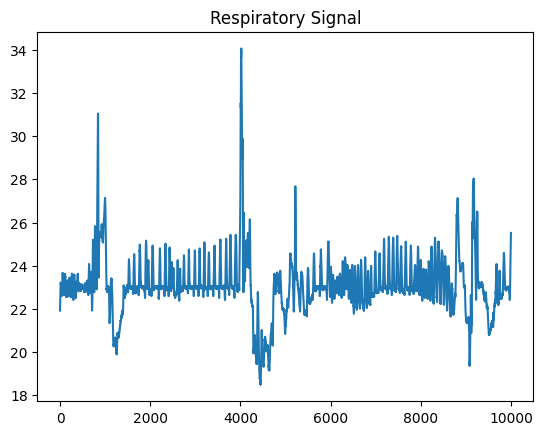

Respiratory rate: 49.00 breaths per minute
Respiratory rate after filter: 122.00 breaths per minute
ECG slp frequecy: 500 Hz
ECG slp interval every: 0.002 sec
RESP slp frequecy: 50 Hz
RESP slp interval every: 0.002 sec

Loading infants 3 ...


/var/folders/hd/p3q1ts813gq7flnfjj_xpf440000gp/T/ipykernel_1852/706675354.py:163: FutureWarning: The frame.append method is deprecated and will be removed from pandas in a future version. Use pandas.concat instead.
  heart_df = heart_df.append(combination)
/var/folders/hd/p3q1ts813gq7flnfjj_xpf440000gp/T/ipykernel_1852/706675354.py:164: FutureWarning: The frame.append method is deprecated and will be removed from pandas in a future version. Use pandas.concat instead.
  resp_df = resp_df.append(combination)


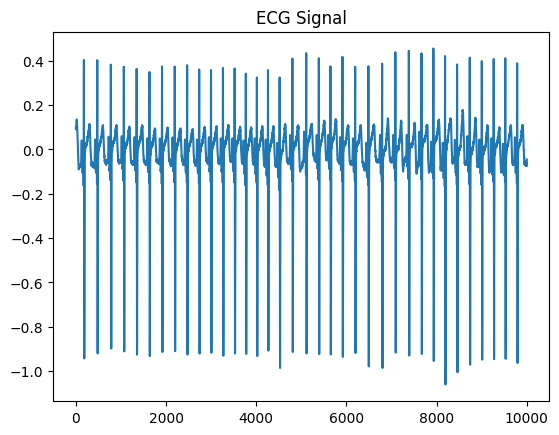

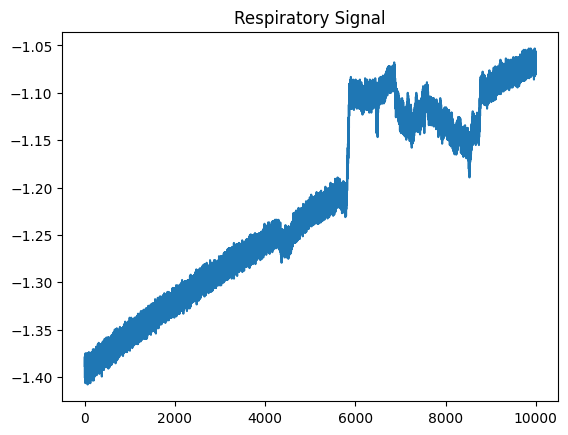

Respiratory rate: 0.00 breaths per minute
Respiratory rate after filter: 601.00 breaths per minute
ECG slp frequecy: 500 Hz
ECG slp interval every: 0.002 sec
RESP slp frequecy: 50 Hz
RESP slp interval every: 0.002 sec

Loading infants 4 ...


/var/folders/hd/p3q1ts813gq7flnfjj_xpf440000gp/T/ipykernel_1852/706675354.py:163: FutureWarning: The frame.append method is deprecated and will be removed from pandas in a future version. Use pandas.concat instead.
  heart_df = heart_df.append(combination)
/var/folders/hd/p3q1ts813gq7flnfjj_xpf440000gp/T/ipykernel_1852/706675354.py:164: FutureWarning: The frame.append method is deprecated and will be removed from pandas in a future version. Use pandas.concat instead.
  resp_df = resp_df.append(combination)


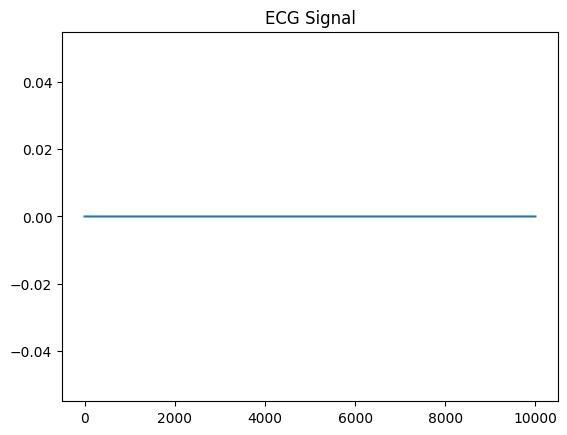

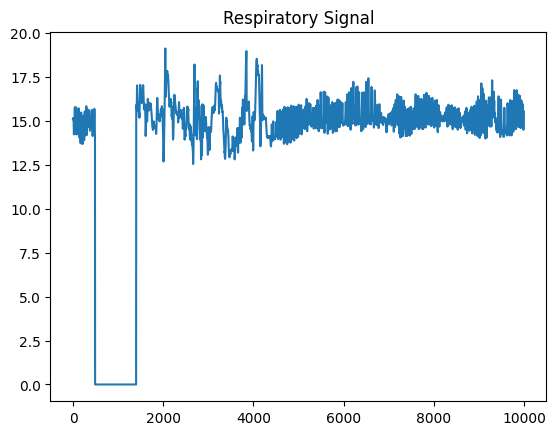

Respiratory rate: 38.00 breaths per minute
Respiratory rate after filter: 106.00 breaths per minute
ECG slp frequecy: 500 Hz
ECG slp interval every: 0.002 sec
RESP slp frequecy: 50 Hz
RESP slp interval every: 0.002 sec

Loading infants 5 ...


/opt/homebrew/lib/python3.10/site-packages/pywt/_thresholding.py:23: RuntimeWarning: invalid value encountered in divide
  thresholded = (1 - value/magnitude)
/var/folders/hd/p3q1ts813gq7flnfjj_xpf440000gp/T/ipykernel_1852/706675354.py:163: FutureWarning: The frame.append method is deprecated and will be removed from pandas in a future version. Use pandas.concat instead.
  heart_df = heart_df.append(combination)
/var/folders/hd/p3q1ts813gq7flnfjj_xpf440000gp/T/ipykernel_1852/706675354.py:164: FutureWarning: The frame.append method is deprecated and will be removed from pandas in a future version. Use pandas.concat instead.
  resp_df = resp_df.append(combination)


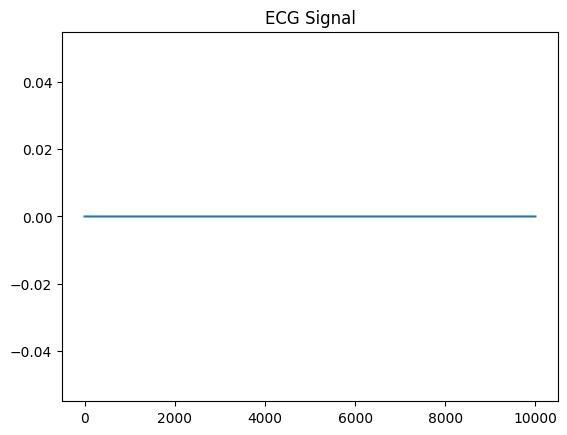

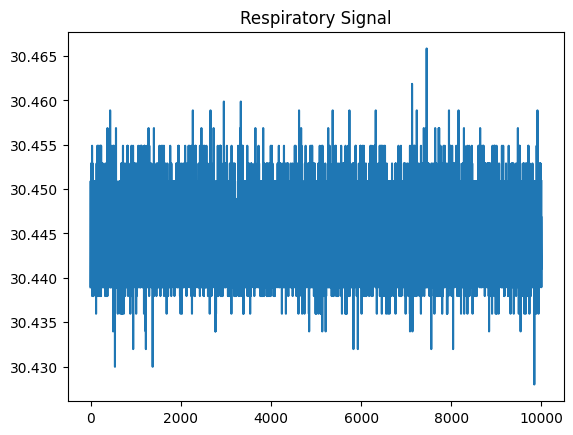

/opt/homebrew/lib/python3.10/site-packages/pywt/_thresholding.py:23: RuntimeWarning: invalid value encountered in divide
  thresholded = (1 - value/magnitude)


Respiratory rate: 0.00 breaths per minute
Respiratory rate after filter: 946.00 breaths per minute
ECG slp frequecy: 250 Hz
ECG slp interval every: 0.004 sec
RESP slp frequecy: 50 Hz
RESP slp interval every: 0.004 sec

Loading infants 6 ...


/var/folders/hd/p3q1ts813gq7flnfjj_xpf440000gp/T/ipykernel_1852/706675354.py:163: FutureWarning: The frame.append method is deprecated and will be removed from pandas in a future version. Use pandas.concat instead.
  heart_df = heart_df.append(combination)
/var/folders/hd/p3q1ts813gq7flnfjj_xpf440000gp/T/ipykernel_1852/706675354.py:164: FutureWarning: The frame.append method is deprecated and will be removed from pandas in a future version. Use pandas.concat instead.
  resp_df = resp_df.append(combination)


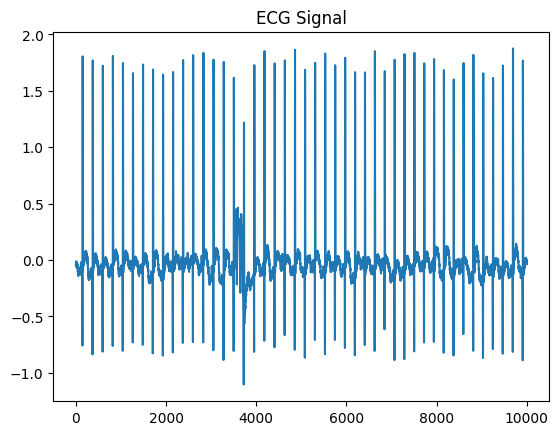

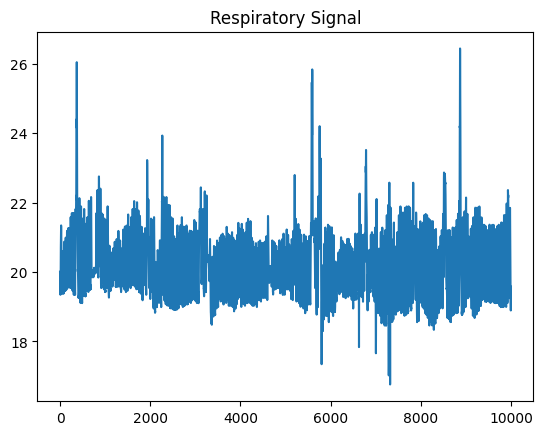

Respiratory rate: 85.00 breaths per minute
Respiratory rate after filter: 249.00 breaths per minute
ECG slp frequecy: 500 Hz
ECG slp interval every: 0.002 sec
RESP slp frequecy: 50 Hz
RESP slp interval every: 0.002 sec

Loading infants 7 ...


/var/folders/hd/p3q1ts813gq7flnfjj_xpf440000gp/T/ipykernel_1852/706675354.py:163: FutureWarning: The frame.append method is deprecated and will be removed from pandas in a future version. Use pandas.concat instead.
  heart_df = heart_df.append(combination)
/var/folders/hd/p3q1ts813gq7flnfjj_xpf440000gp/T/ipykernel_1852/706675354.py:164: FutureWarning: The frame.append method is deprecated and will be removed from pandas in a future version. Use pandas.concat instead.
  resp_df = resp_df.append(combination)


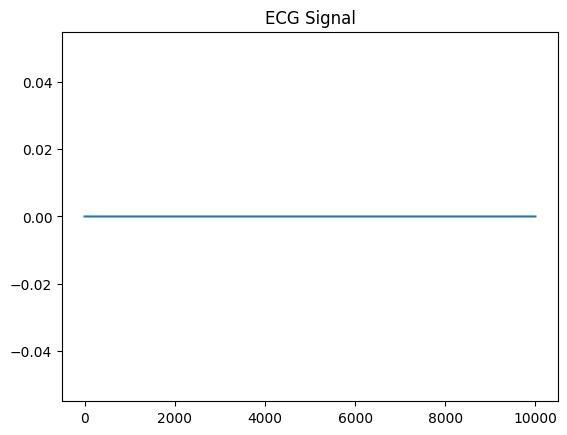

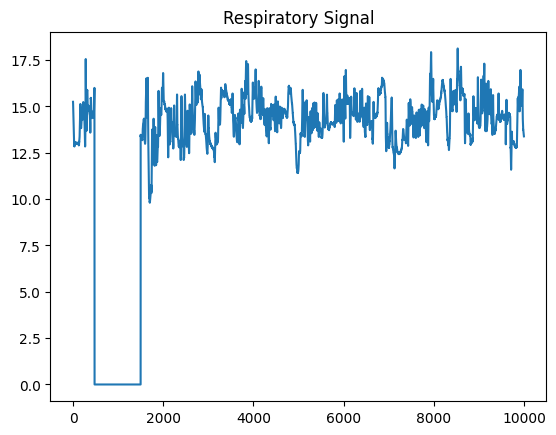

Respiratory rate: 35.00 breaths per minute
Respiratory rate after filter: 110.00 breaths per minute
ECG slp frequecy: 500 Hz
ECG slp interval every: 0.002 sec
RESP slp frequecy: 50 Hz
RESP slp interval every: 0.002 sec

Loading infants 8 ...


/opt/homebrew/lib/python3.10/site-packages/pywt/_thresholding.py:23: RuntimeWarning: invalid value encountered in divide
  thresholded = (1 - value/magnitude)
/var/folders/hd/p3q1ts813gq7flnfjj_xpf440000gp/T/ipykernel_1852/706675354.py:163: FutureWarning: The frame.append method is deprecated and will be removed from pandas in a future version. Use pandas.concat instead.
  heart_df = heart_df.append(combination)
/var/folders/hd/p3q1ts813gq7flnfjj_xpf440000gp/T/ipykernel_1852/706675354.py:164: FutureWarning: The frame.append method is deprecated and will be removed from pandas in a future version. Use pandas.concat instead.
  resp_df = resp_df.append(combination)


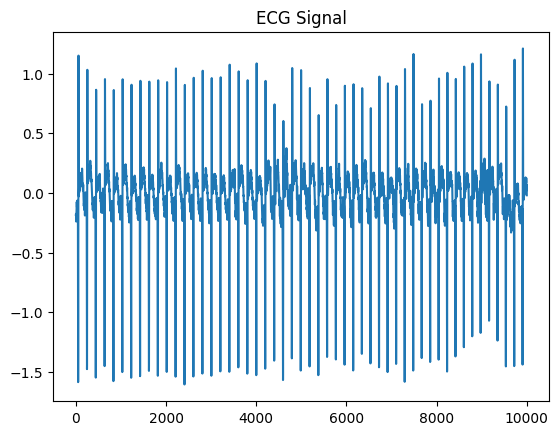

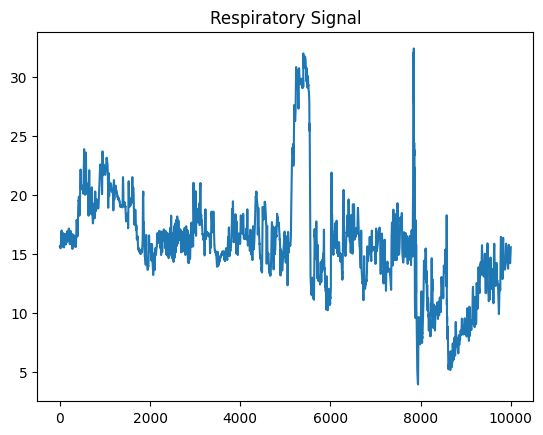

/var/folders/hd/p3q1ts813gq7flnfjj_xpf440000gp/T/ipykernel_1852/706675354.py:163: FutureWarning: The frame.append method is deprecated and will be removed from pandas in a future version. Use pandas.concat instead.
  heart_df = heart_df.append(combination)
/var/folders/hd/p3q1ts813gq7flnfjj_xpf440000gp/T/ipykernel_1852/706675354.py:164: FutureWarning: The frame.append method is deprecated and will be removed from pandas in a future version. Use pandas.concat instead.
  resp_df = resp_df.append(combination)


Respiratory rate: 73.00 breaths per minute
Respiratory rate after filter: 168.00 breaths per minute
ECG slp frequecy: 500 Hz
ECG slp interval every: 0.002 sec
RESP slp frequecy: 50 Hz
RESP slp interval every: 0.002 sec

Loading infants 9 ...


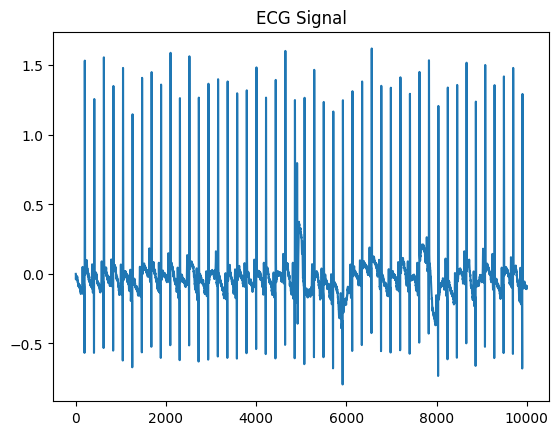

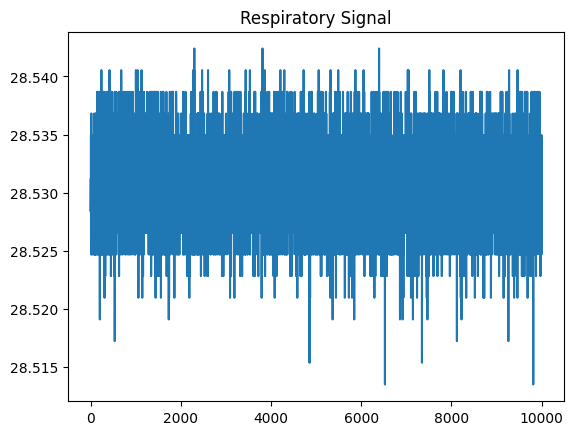

Respiratory rate: 0.00 breaths per minute
Respiratory rate after filter: 973.00 breaths per minute
ECG slp frequecy: 500 Hz
ECG slp interval every: 0.002 sec
RESP slp frequecy: 50 Hz
RESP slp interval every: 0.002 sec

Loading infants 10 ...


/var/folders/hd/p3q1ts813gq7flnfjj_xpf440000gp/T/ipykernel_1852/706675354.py:163: FutureWarning: The frame.append method is deprecated and will be removed from pandas in a future version. Use pandas.concat instead.
  heart_df = heart_df.append(combination)
/var/folders/hd/p3q1ts813gq7flnfjj_xpf440000gp/T/ipykernel_1852/706675354.py:164: FutureWarning: The frame.append method is deprecated and will be removed from pandas in a future version. Use pandas.concat instead.
  resp_df = resp_df.append(combination)


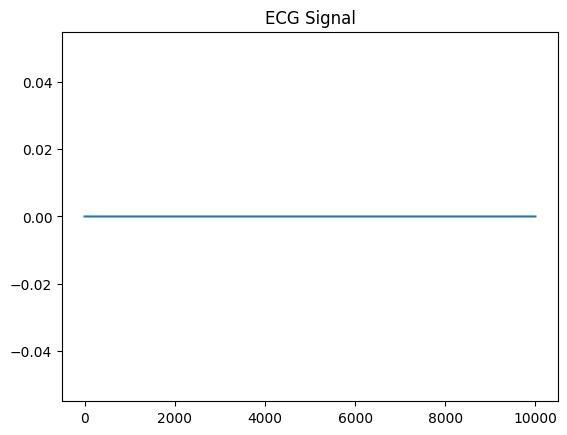

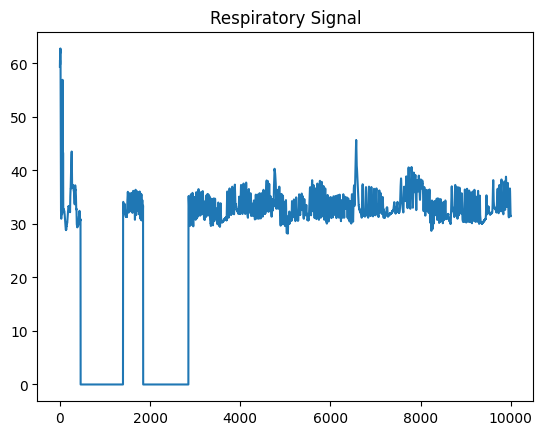

Respiratory rate: 19.00 breaths per minute
Respiratory rate after filter: 110.00 breaths per minute
ECG slp frequecy: 500 Hz
ECG slp interval every: 0.002 sec
RESP slp frequecy: 50 Hz
RESP slp interval every: 0.002 sec

Processed All infants data


/opt/homebrew/lib/python3.10/site-packages/pywt/_thresholding.py:23: RuntimeWarning: invalid value encountered in divide
  thresholded = (1 - value/magnitude)
/var/folders/hd/p3q1ts813gq7flnfjj_xpf440000gp/T/ipykernel_1852/706675354.py:163: FutureWarning: The frame.append method is deprecated and will be removed from pandas in a future version. Use pandas.concat instead.
  heart_df = heart_df.append(combination)
/var/folders/hd/p3q1ts813gq7flnfjj_xpf440000gp/T/ipykernel_1852/706675354.py:164: FutureWarning: The frame.append method is deprecated and will be removed from pandas in a future version. Use pandas.concat instead.
  resp_df = resp_df.append(combination)


In [12]:
  
"""
Step 1: Load sample data for 1..10 infants

heart_data: list of heart rate ECG sample data
resp_data: list of respiratory data

"""
# Constant files
ecg_file = './physionet.org/files/picsdb/1.0.0/infant{}_ecg'
resp_file = './physionet.org/files/picsdb/1.0.0/infant{}_resp'
numbers_infants = 11
sampfrom = 0
sampto = 10000

heart_df = pd.DataFrame(columns=['heart_rate'])
resp_df = pd.DataFrame(columns=['breathing_rate', 'breathing_rate2'])

combinations = []
for i in range(1, numbers_infants):
    print("Loading infants", i, "...")

    ecg_record = wfdb.rdrecord(ecg_file.format(i), sampfrom = sampfrom, sampto = sampto)
    ecg_annotation = wfdb.rdann(ecg_file.format(i), 'qrsc', sampfrom = sampfrom, sampto = sampto)

    resp_record = wfdb.rdrecord(resp_file.format(i), sampfrom = sampfrom, sampto = sampto)
    resp_annotation = wfdb.rdann(resp_file.format(i), 'resp', sampfrom = sampfrom, sampto = sampto)

#     wfdb.plot_wfdb(record=ecg_record, annotation=ecg_annotation,
#                title='Record from ECG',
#                time_units='minutes')
    
#     wfdb.plot_wfdb(record=resp_record, annotation=resp_annotation,
#                title='Record from respiratory',
#                time_units='minutes')

    """DEBUG"""
    # Display record dictionary
    #     display(ecg_record.__dict__)
    #     display(resp_record.__dict__)
    
    # Convert to p_signal
    ecg_p_signal = ecg_record.p_signal
    resp_p_signal = resp_record.p_signal

    # ECG Signal Grpah
    plt.plot(ecg_p_signal)
    plt.title("ECG Signal")
    plt.show()
    
    # Respiratory Signal Grpah
    plt.plot(resp_p_signal)
    plt.title("Respiratory Signal")
    plt.show()

    """ 
    STEP 1
    REFINING THE GRAPH - ECG
    """
    # Use the GQRS algorithm to detect QRS locations in the first channel
    qrs_inds = processing.qrs.gqrs_detect(sig = ecg_record.p_signal, fs = ecg_record.fs)
    
    # Correct the peaks shifting them to local maxima
    min_bpm = 20
    max_bpm = 230
    min_gap = ecg_record.fs * 60 / min_bpm

    denoise_record_p_signal = denoise(ecg_record.p_signal.flatten())
    denoise_record_fs = ecg_record.fs 
    # denoise_record_fs = denoise(ecg_record.fs) 

    # Use the maximum possible bpm as the search radius
#     peaks_hr(sig = ecg_record.p_signal, peak_inds=qrs_inds, fs=ecg_record.fs,
#          title="GQRS peak detection on record 100")
    
#     search_radius = int(denoise_record_fs * 60 / max_bpm)
#     corrected_peak_inds = processing.peaks.correct_peaks(denoise_record_p_signal, 
#                                                          peak_inds=qrs_inds,
#                                                          search_radius=search_radius, 
#                                                          smooth_window_size=150)
#     print(qrs_inds)
#     print('Corrected GQRS detected peak indices:', sorted(corrected_peak_inds))
#     peaks_hr(sig = ecg_record.p_signal, peak_inds = sorted(corrected_peak_inds), fs=ecg_record.fs,
#          title="Corrected GQRS peak detection on sampledata/" + str(sampto))

    """
    STEP 2 - 1
    Calculating the respiratory rate
    """
    # Define the time period for respiratory rate calculation (in seconds)
    time_period = 60

    # Count the number of respiratory peaks in the defined time period
    num_peaks = np.sum((resp_annotation.sample <= time_period * resp_record.fs) & (resp_annotation.sample > 0))

    # Calculate respiratory rate in breaths per minute
    #resp_filter = rr
    rr = num_peaks / time_period * 60
    print('Respiratory rate: {:.2f} breaths per minute'.format(rr))
    
    resp = resp_p_signal.ravel()
    # Perform wavelet decomposition and filtering
    resp_coeffs = pywt.wavedec(resp, 'db4')
    resp_coeffs[1:] = [pywt.threshold(c, value = 0.1 * max(c), mode='hard') for c in resp_coeffs[1:]]
    resp_filtered = pywt.waverec(resp_coeffs, 'db4')

    peaks, _ = find_peaks(resp_filtered)

    # Count the number of respiratory peaks in the defined time period
    num_peaks = np.sum((peaks <= time_period * resp_record.fs) & (peaks > 0))

    # Calculate respiratory rate in breaths per minute
    rr = num_peaks / time_period * 60
    print('Respiratory rate after filter: {:.2f} breaths per minute'.format(rr))
    
    """ 
    STEP 2 - 2
    Calculating the heart rate
    Corelation: 
    heart_rate = by checking
    """
    
    # Heart rate and respiratory rate
    heart_rate = processing.compute_hr(len(ecg_record.p_signal), qrs_inds, ecg_record.fs)
    breathing_rate2 = processing.compute_hr(len(resp_record.p_signal),resp_annotation.sample,resp_record.fs)
    breathing_rate = resp_record.p_signal.flatten()
    
    ecg_samp_interval = 1 / ecg_record.fs
    resp_samp_interval = 1 / resp_record.fs

    print("ECG slp frequecy:", ecg_record.fs, "Hz")
    print("ECG slp interval every:", ecg_samp_interval, "sec")

    print("RESP slp frequecy:" , resp_record.fs, "Hz")
    print("RESP slp interval every:", ecg_samp_interval, "sec")
    print("")
    
    time_ecg = np.arange(ecg_record.p_signal.shape[0]) * ecg_samp_interval
    time_resp = np.arange(resp_record.p_signal.shape[0]) * resp_samp_interval
    
    heart_data = {
        'heart_rate': heart_rate,
        'time': time_ecg,
    }

    resp_data = {
        'breathing_rate': breathing_rate,
        'breathing_rate2': breathing_rate2,
        'time': time_resp, 
    }

    
    # dropna() -> Remove NaN
    x = pd.DataFrame.from_dict(heart_data).fillna(0)
    y = pd.DataFrame.from_dict(resp_data).fillna(0)
#     heart_df.append(x)
#     resp_df.append(y)
    
    combination = pd.merge(x, y, on="time").fillna(0)

    combination =  combination[combination['heart_rate'] != 0]
    combination =  combination[combination['breathing_rate'] != 0]
    combination =  combination[combination['breathing_rate2'] != 0]
    heart_df = heart_df.append(combination)
    resp_df = resp_df.append(combination)

print("Processed All infants data")


In [13]:
print(heart_df,resp_df)

     heart_rate   time  breathing_rate  breathing_rate2
112  120.481926   2.24       23.628713        54.545456
113  120.481926   2.26       23.586601        54.545456
114  120.481926   2.28       23.585197        54.545456
115  120.481926   2.30       23.538171        54.545456
116  120.481926   2.32       23.540979        54.545456
..          ...    ...             ...              ...
995  162.162155  19.90       21.935642       130.434784
996  162.162155  19.92       21.907937       130.434784
997  162.162155  19.94       21.869842       130.434784
998  162.162155  19.96       21.869842       130.434784
999  162.162155  19.98       21.874295       130.434784

[2716 rows x 4 columns]      breathing_rate  breathing_rate2  heart_rate   time
112       23.628713        54.545456  120.481926   2.24
113       23.586601        54.545456  120.481926   2.26
114       23.585197        54.545456  120.481926   2.28
115       23.538171        54.545456  120.481926   2.30
116       23.540979    

In [15]:
"""
STEP 3 Filtering data set
"""
heart_final_df = heart_df.drop(['time', 'breathing_rate', 'breathing_rate2'], axis=1)
resp_final_df = resp_df.drop(['time', 'heart_rate'], axis=1)

heart_list = heart_final_df.values.flatten()
resp_list = resp_final_df.values.tolist()

print(heart_list)
print(resp_list)


[120.481926 120.481926 120.481926 ... 162.16216  162.16216  162.16216 ]
[[23.62871342445016, 54.54545593261719], [23.586600761284647, 54.54545593261719], [23.585197005845796, 54.54545593261719], [23.538171198644307, 54.54545593261719], [23.540978709522008, 54.54545593261719], [23.457455260910407, 54.54545593261719], [23.494654780039944, 54.54545593261719], [23.450436483716153, 54.54545593261719], [23.357788624752025, 54.54545593261719], [23.317781594744787, 54.54545593261719], [23.314974083867085, 54.54545593261719], [23.313570328428234, 54.54545593261719], [23.319185350183638, 54.54545593261719], [23.225835613500085, 54.54545593261719], [23.178107928579166, 54.54545593261719], [23.179511684018017, 54.54545593261719], [23.13810089857193, 54.54545593261719], [23.091776969089864, 54.54545593261719], [23.0398380178524, 54.54545593261719], [22.959823957837923, 54.54545593261719], [22.961227713276774, 54.54545593261719], [22.867176098873795, 54.54545593261719], [22.821554047111153, 54.54545

In [ ]:



"""
STEP 4 Train data set
"""
X_train, X_test, y_train, y_test = train_test_split(resp_list, heart_list, test_size = 0.2, random_state=42)

"""
STEP 3 - 1
Scale the data
"""
# sc_X = StandardScaler()
# sc_y = StandardScaler()
# X = sc_X.fit_transform(X_train)
# y = sc_y.fit_transform(y_train)

# print(X_train)
# print()
# print(y_train)
"""
STEP 3 - 2
# Visualise the data
"""
#     plt.figure()
# #     sns.heatmap(data.corr(), cmap='coolwarm')
#     plt.show()
#     sns.lmplot(x='median_income', y='median_house_value', data = X)
#     sns.lmplot(x='housing_median_age', y='median_house_value', data = y)

"""
Data Modelling 1: SVM
"""
# show unclassified data
# plt.scatter(X_train, Y_train)
# plt.show()

#     np.save("X_train.npy",X_train)
#     np.save("Y_train.npy",Y_train)
#     np.save("X_test.npy",X_test)
#     np.save("Y_test.npy",Y_test)

print("Training Start...")
for i in range(1, 1000):
    clf = svm.SVC(kernel='rbf', C = i)

    lab = preprocessing.LabelEncoder()
    y_transformed = lab.fit_transform(y_train)
    # print(X_train.values.tolist(), y_transformed)
    clf.fit(X_train, y_transformed)

    y_pred = clf.predict(X_test)
    lab = preprocessing.LabelEncoder()
    y_test_transformed = lab.fit_transform(y_test)

    print("Accuracy for ", i ," : ",  metrics.accuracy_score(y_test_transformed, y_pred))
    i = i + 100
    # print(clf.support_)

Training Start...
Accuracy for  1  :  0.15808823529411764
Accuracy for  2  :  0.16176470588235295
Accuracy for  3  :  0.2113970588235294
Accuracy for  4  :  0.24080882352941177
Accuracy for  5  :  0.24080882352941177
Accuracy for  6  :  0.2665441176470588
Accuracy for  7  :  0.26838235294117646
Accuracy for  8  :  0.2702205882352941
Accuracy for  9  :  0.2775735294117647
Accuracy for  10  :  0.28308823529411764
Accuracy for  11  :  0.28860294117647056
Accuracy for  12  :  0.29411764705882354
Accuracy for  13  :  0.30330882352941174
Accuracy for  14  :  0.31066176470588236
Accuracy for  15  :  0.3272058823529412
Accuracy for  16  :  0.3180147058823529
Accuracy for  17  :  0.31985294117647056
Accuracy for  18  :  0.32536764705882354
Accuracy for  19  :  0.3290441176470588
Accuracy for  20  :  0.33455882352941174
Accuracy for  21  :  0.3400735294117647
Accuracy for  22  :  0.3400735294117647
Accuracy for  23  :  0.34191176470588236
Accuracy for  24  :  0.34191176470588236
Accuracy for  25

Accuracy for  206  :  0.42463235294117646
Accuracy for  207  :  0.42463235294117646
Accuracy for  208  :  0.42463235294117646
Accuracy for  209  :  0.42463235294117646
Accuracy for  210  :  0.42463235294117646
Accuracy for  211  :  0.42463235294117646
Accuracy for  212  :  0.4264705882352941
Accuracy for  213  :  0.42830882352941174
Accuracy for  214  :  0.42830882352941174
Accuracy for  215  :  0.42830882352941174
Accuracy for  216  :  0.42830882352941174
Accuracy for  217  :  0.42830882352941174
Accuracy for  218  :  0.43014705882352944
Accuracy for  219  :  0.43014705882352944
Accuracy for  220  :  0.43014705882352944
Accuracy for  221  :  0.43014705882352944
Accuracy for  222  :  0.43014705882352944
Accuracy for  223  :  0.43014705882352944
Accuracy for  224  :  0.43014705882352944
Accuracy for  225  :  0.43014705882352944
Accuracy for  226  :  0.43014705882352944
Accuracy for  227  :  0.43014705882352944
Accuracy for  228  :  0.43014705882352944
Accuracy for  229  :  0.43014705882

Accuracy for  404  :  0.4540441176470588
Accuracy for  405  :  0.4540441176470588
Accuracy for  406  :  0.4540441176470588
Accuracy for  407  :  0.4540441176470588
Accuracy for  408  :  0.4540441176470588
Accuracy for  409  :  0.4540441176470588
Accuracy for  410  :  0.4540441176470588
Accuracy for  411  :  0.4540441176470588
Accuracy for  412  :  0.4540441176470588
Accuracy for  413  :  0.4540441176470588
Accuracy for  414  :  0.4540441176470588
Accuracy for  415  :  0.4540441176470588
Accuracy for  416  :  0.4540441176470588
Accuracy for  417  :  0.45588235294117646
Accuracy for  418  :  0.45588235294117646
Accuracy for  419  :  0.45588235294117646
Accuracy for  420  :  0.45588235294117646
Accuracy for  421  :  0.45588235294117646
Accuracy for  422  :  0.45588235294117646
Accuracy for  423  :  0.45588235294117646
Accuracy for  424  :  0.45588235294117646
Accuracy for  425  :  0.45588235294117646
Accuracy for  426  :  0.45588235294117646
Accuracy for  427  :  0.45588235294117646
Accur

In [26]:
from tensorflow.keras import Model, Input

 
# tf.keras.models.fit(X_train, Y_train, validation_split = "linear")  # validation_split 训练集所占比例
X_train  = [[2,0],[1,1],[2,3]]
y_train = [0,0,1]

X_test = [[2,0],[1,1],[2,3]]
y_test = [1,0,1]


clf = svm.SVC(kernel = 'linear')

clf.fit(X_train,y)

print(clf)

print(clf.support_)

print(clf.predict([[2,0]]))
print(clf.predict([[2,2]]))
print(clf.predict([[2,3]]))


In [40]:




# print("")
# print(X_train[:, 0])

# plt.figure(figsize=(10, 8))
# # Plotting our two-features-space
# sns.scatterplot(x=X_train[:, 0], 
#                 y=X_train[:, 1], 
#                 hue=y_transformed, 
#                 s=8);
# # Constructing a hyperplane using a formula.
# w = clf.coef_[0]           # w consists of 2 elements
# b = clf.intercept_[0]      # b consists of 1 element
# x_points = np.linspace(-1, 1)    # generating x-points from -1 to 1
# y_points = -(w[0] / w[1]) * x_points - b / w[1]  # getting corresponding y-points
# # Plotting a red hyperplane
# plt.plot(x_points, y_points, c='r');

Accuracy: 0.15808823529411764



TypeError: list indices must be integers or slices, not tuple